In [1]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import numpy as np
import math
from math import atan2, pi, sqrt, cos, sin
from cmath import exp
from types import SimpleNamespace
import matplotlib
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 5,5

In [2]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

In [3]:
def onsite(site):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    
    """
    (x, y) = site.pos
    d = y * np.cos(60) + x * np.sin(60)
    if w == 0 and junctionType == 'pp':
            return pot
    else:
        return pot * np.tanh(d / w)

In [4]:
def hopping(site_i, site_j):
    """
    Definition of the hopping parameter by including the magnetic field (parameter phi)
    
    """
    
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return -t * exp(-1j * np.pi * phi / (h/e) * (xi - xj) * (yi + yj)/alat**2)

In [5]:
def make_system(alat=1,W=1,L=1,t=1.0, h_l= 10, w_l=10,d_armEdge=10):
    graphene = kwant.lattice.honeycomb(alat,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def rectangular(pos):
        x, y = pos
        if (L-h_l)/2 < abs(y) < (L)/2:
            return abs(y) < (L)/2 and abs(x) < (W+w_l)/2
        return abs(x) < (W)/2 and abs(y) < (L+d_armEdge)/2 
    def lead_shape1(pos):
        x, y = pos
        return (L-h_l)/2 < abs(y) < L/2
  
    def lead_shape2(pos):
        x, y = pos
        return -W/2 < x < W/2
    
   
    
    sys[graphene.shape(rectangular, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape1, (0, L/2))] = -pot
    lead0[graphene.neighbors()]= hopping
    sys.attach_lead(lead0)
    sys.attach_lead(lead0.reversed())
    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape1, (0, -L/2))] = pot
    lead1[graphene.neighbors()]= hopping
    sys.attach_lead(lead1)
    sys.attach_lead(lead1.reversed())
    
    return sys

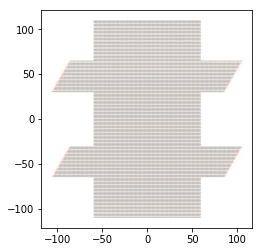

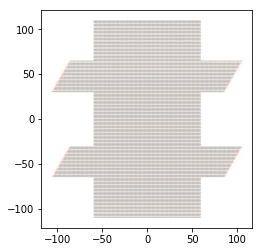

In [6]:
a0 = 0.142e-9 ; alat = 1  # the lattice parameter (real and scaled respectively)
sf = alat/a0
t0 = 2.8 ; t = t0/sf # the hopping terms (real and scaled respectively)
W = 120 ; L = 130 # width and length of the electronic system
n2D = 1e5 # electronic density of suspended graphene
Ef = (3/2) * t * (alat*1e-7) * np.sqrt(np.pi*n2D) # Fermi energy computed from the electronic density
#Ef = 0.1
#Ef = 2*np.pi * t * (a * 1e-9)**2 * n2D # Fermi energy computed from the electronic density
h_l = 70 ; w_l = 50 ; d_armEdge = 90

w = 0
junctionType = 'pp'
pot= 0 # Valeur du potentiel

sys = make_system(alat,W,L,t, h_l, w_l,d_armEdge)


sys = sys.finalized()
kwant.plot(sys)

#ok

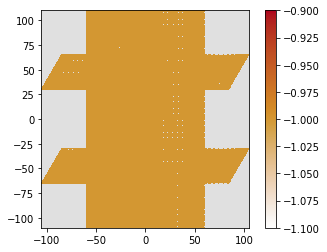

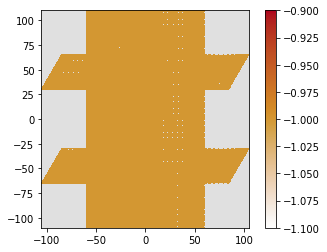

In [7]:
vals=[onsite(sys.sites[n]) for n in range(sys.graph.num_nodes)]
kwant.plotter.map(sys, vals)

In [13]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 3 * pi * alat * t / Ef # computation of the wavelength in graphene
print('Fermi wavelength: ', lambda_F)
print('Scaled lattice parameter: ', alat)
if lambda_F/alat < 2:
    print('Warning : lambda_F must be larger than the lattice parameter alat')
    
""" We must be at low energy density at the level of the Dirac cone """
print('Fermi energy Ef: ', Ef)
print('Scaled hopping energy: ', t)
if Ef/t > (1/2):
    print('Warning : Ef must be smaller than (1/2)t')

Fermi wavelength:  112099.82432795857
Scaled lattice parameter:  1
Fermi energy Ef:  3.342816761459724e-05
Scaled hopping energy:  0.39759999999999995


In [9]:
def plot_transmission(sys, Ef):# params):
    # Compute conductance
    trans = []
    smatrix = kwant.smatrix(sys, Ef)
    trans.append(smatrix.transmission(3, 0))
    plt.plot(B, trans)
    #ok

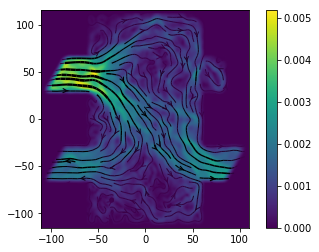

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


In [10]:
B = 0.0
phi = B * 3*np.sqrt(3)/(2) * alat**2
wfs = kwant.wave_function(sys, energy=Ef) # to obtain the wave functions of the system 
#de = kwant.operator.Density(sys)
J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
current = sum(J0(p) for p in wf_left)
#density = sum(de(p) for p in wf_left)
#kwant.plotter.density(graph, density)
kwant.plotter.current(sys, current, cmap='viridis');

Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  inf


/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  2129.7887219158615
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  1505.9880477613358
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  1229.6340919151517
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  1064.8943609579308
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  952.4704719832525
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  869.4826047713664
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  804.9844718999243
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  752.9940238806679
Scaling factor:  7.042253521126761
Magnetic length over the real lattice parameter:  709.9295739719539
Scaling factor:  7.042253521126761
Magnetic length over the real latt

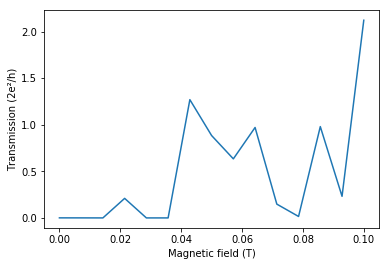

In [11]:
B = 0.1
#phi = B * 3*np.sqrt(3)/(2)*alat**2
#kwant.plotter.bands(sys.leads[0]);

Field = np.linspace(0, B, 15)
trans = []
for A in Field:
    phi = A * 3*np.sqrt(3)/(2)*alat**2
    smatrix = kwant.smatrix(sys, Ef)
    trans.append(smatrix.transmission(1, 0))
    """ The scaling factor must be (much more) smaller than the magnetic length over the real lattice parameter """
    print('Scaling factor: ', sf)
    print('Magnetic length over the real lattice parameter: ', 180/np.sqrt(A))
    if sf > (1/4) * (180/np.sqrt(A)):
        print('Warning : sf must be larger than l_B/ao')
plt.plot(Field,trans)
plt.xlabel('Magnetic field (T)')
plt.ylabel('Transmission (2e²/h)')
plt.show()

0.0


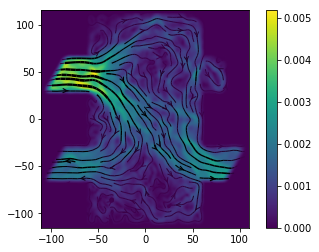

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


0.0071428571428571435


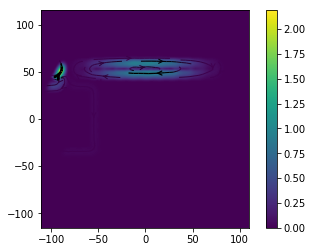

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


0.014285714285714287


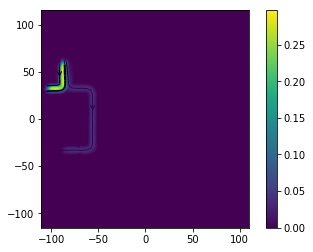

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


0.02142857142857143


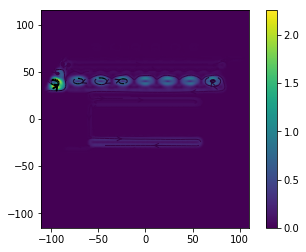

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


0.028571428571428574


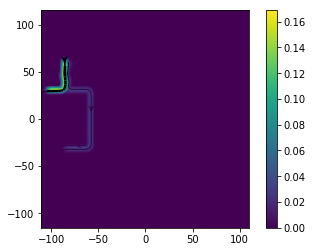

/home/florian/.local/share/Trash/files/anaconda3//lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


KeyboardInterrupt: 

In [12]:
Field = np.linspace(0, B, 15)
for A in Field:
    B = A
    phi = A * 3*np.sqrt(3)/(2)*alat**2
    wfs = kwant.wave_function(sys, energy=Ef) # to obtain the wave functions of the system 
    de = kwant.operator.Density(sys)
    J0 = kwant.operator.Current(sys)
    wf_left = wfs(0)
    current = sum(J0(p) for p in wf_left)
    density = sum(de(p) for p in wf_left)
        #kwant.plotter.density(graph, density)
    print(B)
    kwant.plotter.current(sys, current, cmap='viridis');